<center>
<img src="../images/ods_stickers.jpg" />
    
# Introducción al Machine Learning 2020

Basado en material de Pedro Pury y  Sebastian Raschka (sraschka@wisc.edu) Traducido y editado al español por [Ana Georgina Flesia](https://www.linkedin.com/in/georginaflesia/). Este material esta sujeto a los términos y condiciones de la licencia  [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Se permite el uso irrestricto para todo propósito no comercial.

## 1) Métricas de Evaluación



Un clasificador se entrena para discriminar los ejemplos en tres
clases (A, B y C) y en la evaluación sobre el conjunto de test
se obtiene la siguiente matriz de confusión:

        ------------------------------
                        clasificado
                       A    B     C    
        ------------------------------
                  A |  9    3     1
    etiquetado    B |  4    8     2
                  C |  2    1     6






a) Calcular la proporción de aciertos obtenidos.


In [1]:
aciertos = 9+8+6
total_de_predicciones = 9+4+2+3+8+1+1+2+6
exactitud = aciertos/total_de_predicciones
exactitud

0.6388888888888888

b)  Calcular un intervalo de confianza del $95\%$ para
la métrica de exactitud. \\
Justificar si es válida la aproximación normal para el cálculo.



Si consideramos X = la va que mide la cantidad de aciertos del clasificador, X es una variable aleatoria de Bernoulli. Las proporciones de una Bernoulli tiene distribucion binomial, que con muestras grandes (>30 podria ser) puede ser aproximada por una Gaussiana. Asi que sí, es válida una aproximacion normal.

Vamos a calcular el intervalo de confianza para la proporcion de aciertos con la formula presentada en clase, de la siguiente forma:

$$p = \frac{\hat{p} + \frac{z^2}{2n} \pm \sqrt{\hat{p}(1-\hat{p})\frac{z^2}{n}+\frac{z^4}{4n}}}{1+\frac{z^2}{n}}$$
Para un intervalo de confianza de 95%, z=1.96

In [2]:
from scipy.stats import norm
from math import sqrt
alpha = 0.05
n = total_de_predicciones
z = 1.96
z_cuad = z**2
p = exactitud
p_superior = (p + z_cuad/2*n + sqrt(p*(1-p)*(z_cuad/n) + z_cuad**2/(4*n)))/(1+z_cuad/n) 
p_inferior = (p + z_cuad/2*n - sqrt(p*(1-p)*(z_cuad/n) + z_cuad**2/(4*n)))/(1+z_cuad/n)
print("Un intervalo de confianza del 95% para la exactitud es: ({},{})".format(p_inferior,p_superior))
print("La longitud del intervalo de confianza es:{}".format(p_superior-p_inferior))

Un intervalo de confianza del 95% para la exactitud es: (62.7364908413606,63.38077352553227)
La longitud del intervalo de confianza es:0.6442826841716709


c)  Calcular el coeficiente $\kappa$ de Cohen.
¿Qué grado de confiabilidad tiene el clasificador?

El coeficiente $\kappa$ de Cohen mide el ratio de acuerdo entre dos clasificadores presuntamente independientes. Esto nos otorga una buena medida de la reproducibilidad del clasificador, ya que la medida ademas toma en cuenta los acuerdos que se producen en forma casual.  
¿Cómo se calcula?  

$$\kappa = \frac{p_{o}-p_{\epsilon}}{1-p_{\epsilon}}$$

Donde $p_{o}$ son los acuerdos observados y $p_{\epsilon}$ la proporcion de acuerdo independiente, es decir la probabilidad hipotetica de que los clasificadores acuerden por azar.


In [3]:
p_o = (9+8+6)/n
# Ahora calculamos las probabilidades de acuerdo.
# Probabilidad de que el clasificador clasifique cada valor:
pc_A = (9+4+2)/n
pc_B = (3+8+4)/n
pc_C = (1+2+6)/n
# Probabilidad de que la etiqueta sea cada valor
pe_A = (9+3+4)/n
pe_B = (4+8+2)/n
pe_C = (2+1+6)/n
# Ahora calculamos p_e, es decir, la probabilidad de que coincidan aleatoriamente
p_e = pc_A * pe_A + pc_B * pe_B + pc_C * pe_C
kcohen = (p_o - p_e)/(1-p_e)
print("El coheficiente k es: {}".format(kcohen))

El coheficiente k es: 0.388235294117647


La confiabilidad en el acuerdo es baja, osea, no tenemos un clasificador muy confiable

## 2) Bagging

En esta segunda parte de esta tarea, combinará múltiples árboles de decisión dentro de un clasificadorde Bagging. Esta vez, utilizaremos el algoritmo del árbol de decisión `DecisionTreeClassifier` implementado en scikit-learn (que es una variante del algoritmo CART para divisiones binarias).


### 2.1 Bootsrapping

Bagging depende del muestreo bootstrap. Entonces, como primer paso, su tarea es implementar una función para generar muestras de arranque. En este ejercicio, por simplicidad, realizaremos los cálculos basados en el conjunto de datos de Iris.



In [4]:
# DO NOT EDIT OR DELETE THIS CELL
import numpy as np
from mlxtend.data import iris_data
X, y = iris_data()

print('Number of examples:', X.shape[0])
print('Number of features:', X.shape[1])
print('Unique class labels:', np.unique(y))

Number of examples: 150
Number of features: 4
Unique class labels: [0 1 2]


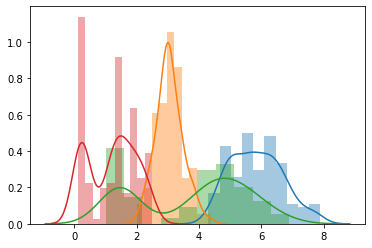

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
fig,ax=plt.subplots()
ax = sns.distplot(X[:,[0]],bins=10)
ax = sns.distplot(X[:,[1]],bins=10)
ax = sns.distplot(X[:,[2]],bins=10)
ax = sns.distplot(X[:,[3]],bins=10)

Usaremos la función de scikit-learn `train_test_split` 
función para dividir el conjunto de datos en un conjunto de entrenamiento y prueba.


- El conjunto de prueba debe contener 45 ejemplos, y el conjunto de entrenamiento debe contener 105 ejemplos.
- Para garantizar resultados reproducibles, utilice '123' como semilla aleatoria.
- Realice una división estratificada.

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=45,
                                                    train_size=105,
                                                    random_state=123,
                                                    stratify=y
                                                   )

print('Number of training examples:', X_train.shape[0])
print('Number of test examples:', X_test.shape[0])

Number of training examples: 105
Number of test examples: 45


Agregué la siguiente celda de código para su conveniencia para verificar su solución. Si sus resultados no coinciden con los resultados que se muestran a continuación, hay un error en su implementación.

In [7]:
# DO NOT EDIT OR DELETE THIS CELL

print('Number of training examples:', X_train.shape[0])
print('Number of test examples:', X_test.shape[0])


#Number of training examples: 105
#Number of test examples: 45


Number of training examples: 105
Number of test examples: 45


A continuación, estamos implementando una función para generar muestras bootstrap del conjunto de entrenamiento. En particular, realizaremos el bootstrapping de la siguiente manera:

- Cree una matriz de índice con valores 0, ..., 104.
- Extraiga una muestra aleatoria (con reemplazo) de esta matriz de índices utilizando el método  `choice` del objeto `RandomState` de  NumPy  que se pasa a la función como rng.
- Seleccione ejemplos de entrenamiento de la matriz X y etiquetas del vector y utilizando la nueva muestra de índices.

In [8]:
def draw_bootstrap_sample(rng, X, y):
    sample_indices = [ i for i in range(105)]
    bootstrap_indices = rng.choice(sample_indices,105)
    return X[bootstrap_indices], y[bootstrap_indices]


Agregué la siguiente celda de código para su conveniencia para verificar su solución. Si sus resultados no coinciden con los resultados que se muestran a continuación, hay un error en su implementación de la función `draw_bootstrap_sample`.

In [9]:
# DO NOT EDIT OR DELETE THIS CELL

rng = np.random.RandomState(123)
X_boot, y_boot = draw_bootstrap_sample(rng, X_train, y_train)

print('Number of training inputs from bootstrap round:', X_boot.shape[0])
print('Number of training labels from bootstrap round:', y_boot.shape[0])
print('Labels:\n', y_boot)

#Number of training inputs from bootstrap round: 105
#Number of training labels from bootstrap round: 105
#Labels:
# [0 0 1 0 0 1 2 0 2 1 0 0 2 1 1 1 1 2 1 1 2 0 2 1 2 1 1 1 0 1 0 0 1 2 0 0 0
# 0 2 1 1 2 1 2 1 1 2 1 2 0 1 1 2 2 1 0 1 0 2 2 0 1 0 2 0 0 0 0 1 2 0 0 1 0
# 1 1 0 1 1 2 2 0 2 0 2 0 1 1 2 2 0 2 2 2 0 1 0 1 2 2 2 1 0 0 0]

Number of training inputs from bootstrap round: 105
Number of training labels from bootstrap round: 105
Labels:
 [0 0 1 0 0 1 2 0 2 1 0 0 2 1 1 1 1 2 1 1 2 0 2 1 2 1 1 1 0 1 0 0 1 2 0 0 0
 0 2 1 1 2 1 2 1 1 2 1 2 0 1 1 2 2 1 0 1 0 2 2 0 1 0 2 0 0 0 0 1 2 0 0 1 0
 1 1 0 1 1 2 2 0 2 0 2 0 1 1 2 2 0 2 2 2 0 1 0 1 2 2 2 1 0 0 0]


### 2.2 Clasificador Baggging a partir de árboles de decisión. 


En esta sección, Ud implementará un algoritmo de bagging basado en `DecisionTree Classifier`. Como ayuda se proporciona una solución parcial.

In [10]:
from sklearn.tree import DecisionTreeClassifier


class BaggingClassifier(object):
    
    def __init__(self, num_trees=10, random_state=123):
        self.num_trees = num_trees
        self.rng = np.random.RandomState(random_state)
        
        
    def fit(self, X, y):
        self.trees_ = [DecisionTreeClassifier(random_state=self.rng) for i in range(self.num_trees)]
        for i in range(self.num_trees):
            X_boot, y_boot = draw_bootstrap_sample(self.rng, X, y)
            self.trees_[i] = self.trees_[i].fit(X_boot,y_boot)
            
    def predict(self, X):
        ary = np.zeros((X.shape[0], len(self.trees_)), dtype=np.int)
        for i in range(len(self.trees_)):
            ary[:, i] = self.trees_[i].predict(X)

        maj = np.apply_along_axis(lambda x:
                                  np.argmax(np.bincount(x)),
                                            axis=1,
                                            arr=ary)
        return maj

Agregué la siguiente celda de código para su conveniencia para verificar su solución. Si sus resultados no coinciden con los resultados que se muestran a continuación, hay un error en su implementación de la función `BaggingClassifier()`.

In [11]:
# DO NOT EDIT OR DELETE THIS CELL
model = BaggingClassifier()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

print('Individual Tree Accuracies:')
for tree in model.trees_:
    predictions = tree.predict(X_test) 
    print('%.1f%%' % ((predictions == y_test).sum() / X_test.shape[0] * 100))

print('\nBagging Test Accuracy: %.1f%%' % ((predictions == y_test).sum() / X_test.shape[0] * 100))

#Individual Tree Accuracies:
#88.9%
#93.3%
#97.8%
#93.3%
#93.3%
#93.3%
#91.1%
#97.8%
#97.8%
#97.8%

#Bagging Test Accuracy: 97.8%

Individual Tree Accuracies:
88.9%
93.3%
97.8%
93.3%
93.3%
93.3%
91.1%
97.8%
97.8%
97.8%

Bagging Test Accuracy: 97.8%


## 3) Descomposición de sesgo-varianza 


En este ejercicio se le pedirá que calcule los componentes de varianza y sesgo de la función de pérdida 0-1 que discutimos en clase.

- En particular, calculará el sesgo promedio y la varianza promedio sobre todos los ejemplos de prueba (en lugar de un solo ejemplo de prueba).

- El conjunto de datos que utilizará como conjunto de entrenamiento y conjunto de prueba es el conjunto de datos de Iris que ya dividió en `X_train` /` y_train` y `X_test` /` y_test` anteriormente.

- Dado que no tenemos conjuntos de datos de entrenamiento ilimitados para estimar los parámetros, utilizaremos bootstrapping para simular "nuevos" conjuntos de entrenamiento.

### 3.1 Descomposición de sesgo-varianza  de la pérdida 0-1 para árboles de decisión



En esta primera parte, calculará los  sesgo y varianza promedios sobre los ejemplos del conjunto de prueba para el algoritmo del árbol de decisión implementado en scikit-learn en los datos de Iris.

Ya implementé el código para calcular la "predicción principal" para usted:

In [12]:
# DO NOT EDIT OR DELETE THIS CELL

rng = np.random.RandomState(123)

num_bootstrap = 200
# Creamos un arreglo para calcular las predicciones principales de cada
# muestra de bootstrap
all_pred = np.zeros((num_bootstrap, y_test.shape[0]), dtype=np.int)

# Predecimos sobre el conjunto de test, para cada una de las muestras
# de bootstraping
tree = DecisionTreeClassifier(random_state=66)
for i in range(num_bootstrap):
    X_boot, y_boot = draw_bootstrap_sample(rng, X_train, y_train)
    pred = tree.fit(X_boot, y_boot).predict(X_test)
    all_pred[i] = pred
    
# Calculamos las predicciones principales como la moda de cada una de las predicciones    
main_predictions = np.apply_along_axis(lambda x:
                                       np.argmax(np.bincount(x)),
                                       axis=0,
                                       arr=all_pred)

Tenga en cuenta que `all_pred` es una matriz 2D de dimensión $\mathbb{R}^{b \times n_{test}}$, donde $m$ es el número de iteraciones bootstrap  y $n_{test}$ es el número de ejemplos en el conjunto de prueba. En otras palabras, cada una de las 200 filas de esta matriz almacena las predicciones de una hipótesis de árbol de decisión en particular para los 45 puntos de datos de prueba.

Su primera tarea es calcular el sesgo promedio sobre todos los ejemplos de prueba:

El sesgo es 1 si la predicción principal no coincide con la verdadera etiqueta $y$ y 0 en otro caso.

In [13]:
main_predictions

array([1, 2, 1, 1, 2, 0, 0, 1, 0, 0, 2, 0, 2, 0, 1, 0, 2, 2, 0, 0, 0, 0,
       0, 1, 0, 1, 2, 0, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 0, 2, 1, 1, 2,
       1])

In [16]:
# YOUR CODE
def L(y_pred,y):
    return y_pred != y

def calculate_bias(preds,main_preds):
    bias = 0
    for pred,main_pred in zip(preds,main_preds):
        bias += L(pred,main_pred)
    return bias/len(preds)


def avg_bias(all_pred,main_predictions):
    biass = []
    for i in range(len(all_pred)):
        biass.append(calculate_bias(all_pred[i],main_predictions))
    return np.mean(biass)

bias = avg_bias(all_pred,main_predictions)
print('Average bias:', bias)

Average bias: 0.034555555555555555


Su segunda tarea es calcular la varianza promedio sobre todos los ejemplos de prueba:

In [19]:
# YOUR CODE
# you probably need multiple
# lines of code and a for-loop

# La varianza de la peridad 0-1 se mide como la probabilidad
# de que la etiqueta principal no coincida con la muestra.
# Para calcularla, vamos a devolver el promedio de en cuantos
# casos coincide y en cuantos no
def calc_var(preds,main_preds):
    coincidences = 0
    for y_pred,main_pred in zip(preds,main_preds):
        coincidences += y_pred == main_pred
    var = coincidences/len(preds)
    return var

def avg_var(all_pred,main_predictions):
    variances = [] 
    for i in range(len(main_predictions)):
        variances.append(calculate_variance(all_pred[i],main_predictions))
    return np.mean(variances)

var = avg_var(all_pred,main_predictions)
print('Average variance:', var)

Average variance: 0.9644444444444445


Sugerencia: Los valores promedio de sesgo y varianza son escalares, no vectores o matrices. En otras palabras, para cada una de las celdas de código anteriores, debe devolver un número real (float).

### 3.2 Descomposición de sesgo-varianza  de la pérdida 0-1 para Bagging 

- Utilice el código de la sección anterior, 3.1, para comparar el algoritmo del árbol de decisión con un BaggingClassifier de scikit-learn.

- Informe tanto el sesgo promedio como la varianza promedio como antes, pero use el `BaggingClassifier` en scikit-learn en lugar del` DecisionTreeClassifier`. Puede usar los valores predeterminados de `BaggingClassifier`.

In [21]:
from sklearn.ensemble import BaggingClassifier
# YOUR SOLUTION
# Many lines of code (which you may copy and modify from 3.1)
all_pred = np.zeros((num_bootstrap, y_test.shape[0]), dtype=np.int)

# Predecimos sobre el conjunto de test, para cada una de las muestras
# de bootstraping
bagging = BaggingClassifier(random_state=66)
for i in range(num_bootstrap):
    X_boot, y_boot = draw_bootstrap_sample(rng, X_train, y_train)
    pred = bagging.fit(X_boot, y_boot).predict(X_test)
    all_pred[i] = pred
    
# Calculamos las predicciones principales como la moda de cada una de las predicciones    
main_predictions = np.apply_along_axis(lambda x:
                                       np.argmax(np.bincount(x)),
                                       axis=0,
                                       arr=all_pred)


In [22]:
bias = avg_bias(all_pred,main_predictions)
var = avg_var(all_pred,main_predictions)
print('Average bias:', bias)
print('Average variance:', var)

Average bias: 0.025666666666666664
Average variance: 0.979259259259259


¿Es la varianza promedio de bagging mayor o menor que la varianza promedio del árbol de decisión en 3.1? ¿Y qué hay del sesgo promedio? 

La varianza promedio y el sesgo promedio resultan muy similares porque en este dataset lo que no se pueden clasificar son unos pocos ejemplos...

### 3.3 Descomposición de sesgo-varianza  de la pérdida 0-1 para  AdaBoost 


- Utilice el código de la sección anterior, 3.1, para comparar el algoritmo del árbol de decisión con un AdaBoostClassifier de scikit-learn.

- Informe tanto el sesgo promedio como la varianza promedio como antes, pero use el `AdaboostClassifier` en scikit-learn en lugar del` DecisionTreeClassifier`. Puede usar los valores predeterminados de `AdaboostClassifier`.

In [24]:
# YOUR SOLUTION
# Many lines of code (which you may copy and modify from 3.1)

from sklearn.ensemble import AdaBoostClassifier
# YOUR SOLUTION
# Many lines of code (which you may copy and modify from 3.1)
all_pred = np.zeros((num_bootstrap, y_test.shape[0]), dtype=np.int)

# Predecimos sobre el conjunto de test, para cada una de las muestras
# de bootstraping
for i in range(num_bootstrap):
    X_boot, y_boot = draw_bootstrap_sample(rng, X_train, y_train)
    pred = AdaBoostClassifier(random_state=66).fit(X_boot, y_boot).predict(X_test)
    all_pred[i] = pred
    
# Calculamos las predicciones principales como la moda de cada una de las predicciones    
main_predictions = np.apply_along_axis(lambda x:
                                       np.argmax(np.bincount(x)),
                                       axis=0,
                                       arr=all_pred)


In [25]:
bias = avg_bias(all_pred,main_predictions)
var = avg_var(all_pred,main_predictions)
print('Average bias:', bias)
print('Average variance:', var)

Average bias: 0.032
Average variance: 0.9758024691358023


¿Es la varianza promedio de bagging mayor o menor que la varianza promedio del árbol de decisión en 3.1? ¿Y qué hay del sesgo promedio? 

De nuevo, es todo muy parecido porque el problema son unos poquitos ejemplos que no logra clasificar. No obtenemos una gran mejoria

<br>
<br>
<br>
<br>
<br>
<br>

## 4)  Random Forest


En este ejercicio se lepide que  que aplique un `RandomForestClassifier` en un pequeño subconjunto (10%) del conjunto de datos de dígitos manuscritos MNIST (http://yann.lecun.com/exdb/mnist/). Por conveniencia, el siguiente código carga este pequeño subconjunto a través de mlxtend:

In [31]:
from mlxtend.data import mnist_data
X, y = mnist_data()

print('Dimensions: %s x %s' % (X.shape[0], X.shape[1]))
print('1st row', X[0])

Dimensions: 5000 x 784
1st row [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.  51. 159. 253. 159.  50.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  48. 238. 252. 252. 252. 237.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  54.
 227. 253. 252. 239. 233. 252.  57.   6.   0. 


El siguiente código muestra como se mezcla el conjunto de datos y se lo divide en 4500 ejemplos de entrenamiento y 500 ejemplos de prueba, respectivamente.

In [32]:
from mlxtend.preprocessing import shuffle_arrays_unison


X, y = shuffle_arrays_unison((X, y), random_seed=1)
X_train, y_train = X[:4500], y[:4500]
X_test, y_test = X[4500:], y[4500:]


Ahora, su tarea es ajustar un clasificador RandomForest en el conjunto de entrenamiento y evaluar su precisión predictiva en el conjunto de prueba.

In [43]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=123)
model.fit(X_train,y_train)

acc = model.score(X_test,y_test)
print('Accuracy {:.2f}%'.format(acc*100))
    
#Accuracy 93.6%

Accuracy 93.60%




Luego, su tarea es cargar una imagen de un dígito (some_digit.png) de este directorio en una matriz de Python y clasificarla usando el modelo de bosque aleatorio. La imagen some_digit.png se muestra a continuación:

![](images/some_digit.png)


Nota: Para cargar la imagen, debe instalar la biblioteca de imágenes Python PIL. En realidad, es mas recomendable instalar  Pillow. Ejecute uno de los siguientes dos si aún no ha instalado Pillow.
    
- `conda install Pillow`

- `pip install Pillow`

Nuevamente, preescribí parcialmente el código para usted.

In [44]:
from PIL import Image
import numpy as np

def load_image(file_name):
    img = Image.open(file_name)
    img.load()
    data = np.asarray(img, dtype=np.float)
    return data

x_image = load_image('images/some_digit.png')

In [57]:
# The data needs to be represented as a vector (1 position for each feature)
x_transf = [item for sublist in x_image for item in sublist]

# Also, scikit-learn expects 2D arrays, so we need to add a dimension
x_transf = np.expand_dims(x_transf,axis=0)

print('Digit:', model.predict(x_transf)[0])

Digit: 5
